# Inverse Probability Weighting Summary

This notebook summarizes how inverse probability weights (IPW) are incorporated into the Aladyn survival modeling pipeline and highlights the main outputs generated during the latest weighted run.

- **Model training notebook**: `pyScripts_forPublish/aladynoulli_fit_for_understanding_and_discovery_withweights.ipynb`
- **Weighted model implementation**: `pyScripts_forPublish/weighted_aladyn.py`
- **Population weighting visuals (R)**: `Library/CloudStorage/Dropbox-Personal/UKBWeights-main/runningviasulizingweights.R`

The goal here is to provide a concise overview for collaborators who only need the key outcomes, while pointing to the full notebooks for reproducibility.


## Workflow Recap

1. **Compute/Curate Weights**
   - The R script `runningviasulizingweights.R` loads the UK Biobank cohort with Lasso-derived participation weights (`LassoWeight`).
   - It standardizes demographic and health variables, then exports CSV/PNG summaries (`population_weighting_summary.csv`, `weights_by_subgroup.csv`, and comparison plots).
2. **Train Weighted Aladyn Model**
   - `weighted_aladyn.py` extends the core Aladyn survival module with a weighted loss (`compute_loss`) that rescales each participant's likelihood contribution by their IPW.
   - The notebook `aladynoulli_fit_for_understanding_and_discovery_withweights.ipynb` runs the full pipeline, including model initialization, training, and diagnostics against the legacy (unweighted) phi trajectories.
3. **Compare Against Historic (Unweighted) Fits**
   - Within the training notebook, combined phi tensors from historical runs are contrasted with the weighted runs to quantify shifts and produce fairness diagnostics.

The remainder of this summary notebook focuses on the population-level weighting outputs that downstream analysts typically consult.


In [1]:
import pandas as pd
from pathlib import Path

base_path = Path("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/UKBWeights-main")

population_summary_path = base_path / "population_weighting_summary.csv"
weights_by_group_path = base_path / "weights_by_subgroup.csv"

population_summary = pd.read_csv(population_summary_path)
weights_by_group = pd.read_csv(weights_by_group_path)

population_summary


,Category,Unweighted,Weighted,Difference,Pct_Change
0,Age 60+,92.115054,83.974975,-8.140079,-8.836860
1,White British,89.330491,84.021691,-5.308800,-5.942876
2,University Degree,32.984562,28.661119,-4.323443,-13.107474
3,Good/Excellent Health,74.803909,72.866455,-1.937454,-2.590044


In [2]:
weights_by_group


,Group,Mean_Weight,Over_Under
0,Good Health,0.906118,Over-represented\n(Weight < 1)
1,Fair/Poor Health,1.001739,Under-represented\n(Weight > 1)
2,Age 60+,0.848009,Over-represented\n(Weight < 1)
3,Age <60,1.890520,Under-represented\n(Weight > 1)
4,White British,0.874929,Over-represented\n(Weight < 1)
5,Other Ethnicity,1.393053,Under-represented\n(Weight > 1)
6,Female,0.867859,Over-represented\n(Weight < 1)
7,Male,1.004894,Under-represented\n(Weight > 1)
8,University Degree,0.808284,Over-represented\n(Weight < 1)
9,No University Degree,0.990222,Over-represented\n(Weight < 1)


In [3]:
top_diffs = population_summary.reindex(population_summary['Difference'].abs().sort_values(ascending=False).index)
top_diffs[['Category', 'Unweighted', 'Weighted', 'Difference', 'Pct_Change']].head()


,Category,Unweighted,Weighted,Difference,Pct_Change
0,Age 60+,92.115054,83.974975,-8.140079,-8.836860
1,White British,89.330491,84.021691,-5.308800,-5.942876
2,University Degree,32.984562,28.661119,-4.323443,-13.107474
3,Good/Excellent Health,74.803909,72.866455,-1.937454,-2.590044


In [4]:
weights_by_group.sort_values('Mean_Weight').reset_index(drop=True)


,Group,Mean_Weight,Over_Under
0,University Degree,0.808284,Over-represented\n(Weight < 1)
1,Age 60+,0.848009,Over-represented\n(Weight < 1)
2,Female,0.867859,Over-represented\n(Weight < 1)
3,White British,0.874929,Over-represented\n(Weight < 1)
4,Good Health,0.906118,Over-represented\n(Weight < 1)
5,No University Degree,0.990222,Over-represented\n(Weight < 1)
6,Fair/Poor Health,1.001739,Under-represented\n(Weight > 1)
7,Male,1.004894,Under-represented\n(Weight > 1)
8,Other Ethnicity,1.393053,Under-represented\n(Weight > 1)
9,Age <60,1.890520,Under-represented\n(Weight > 1)


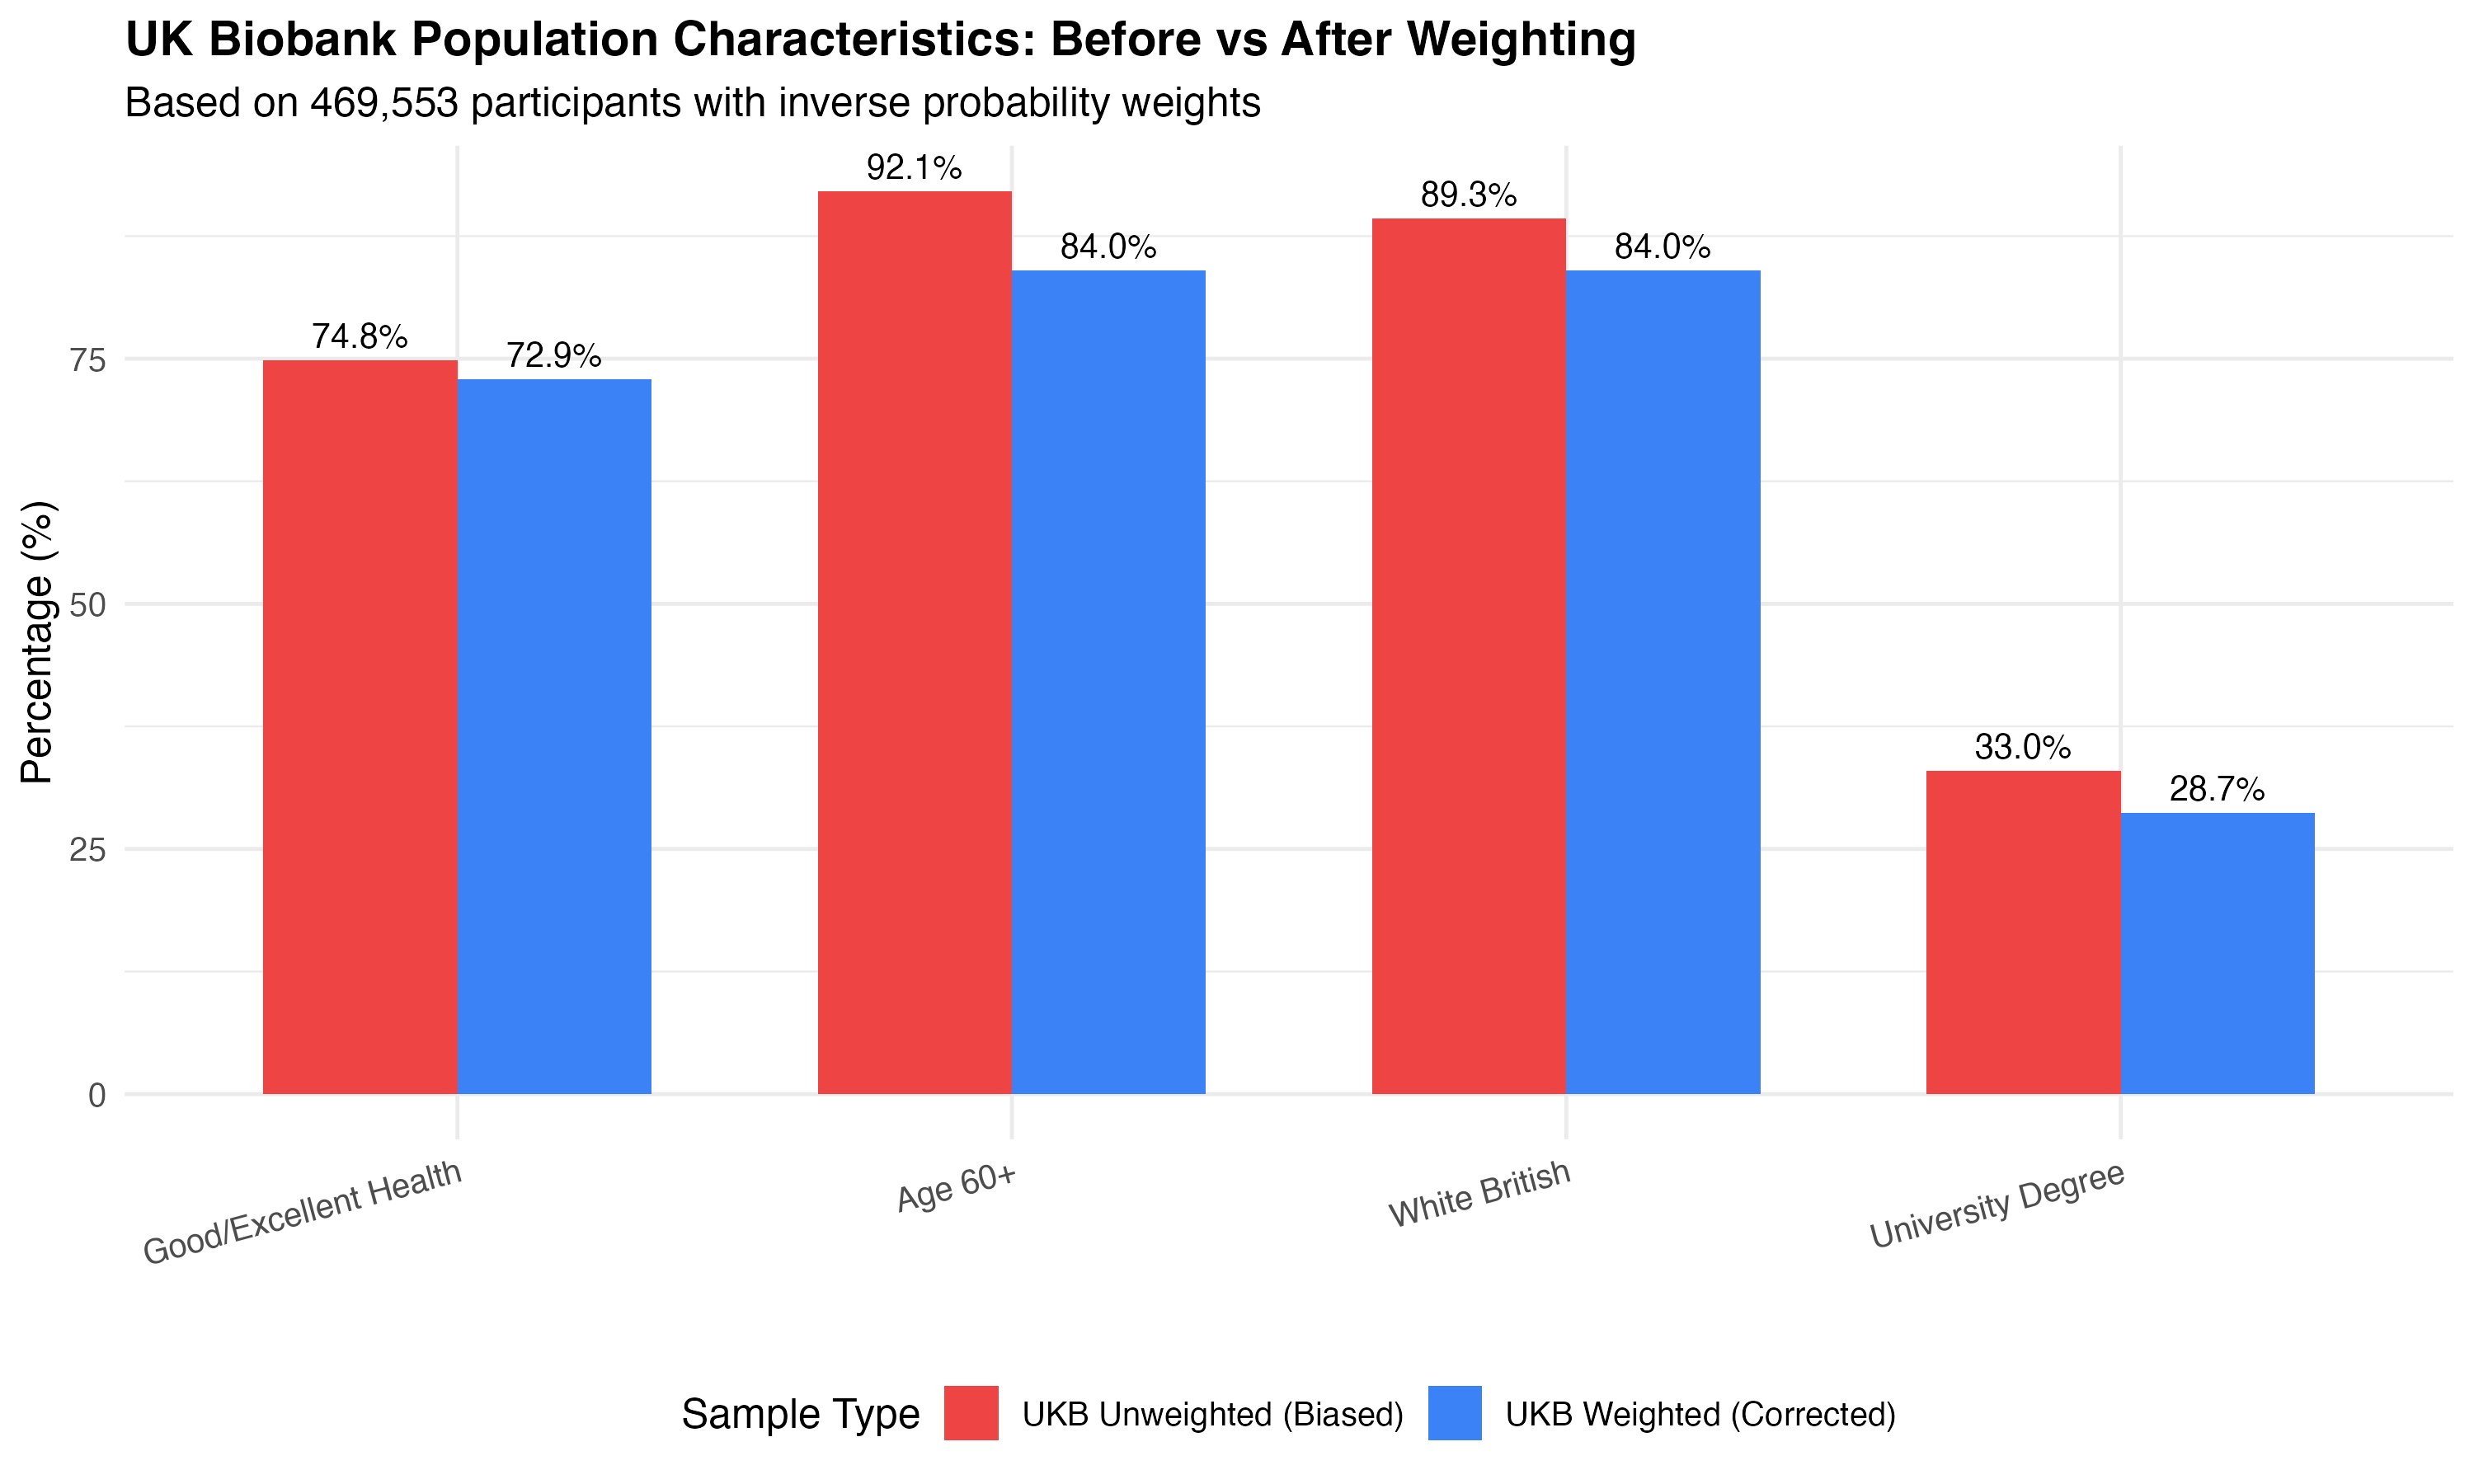

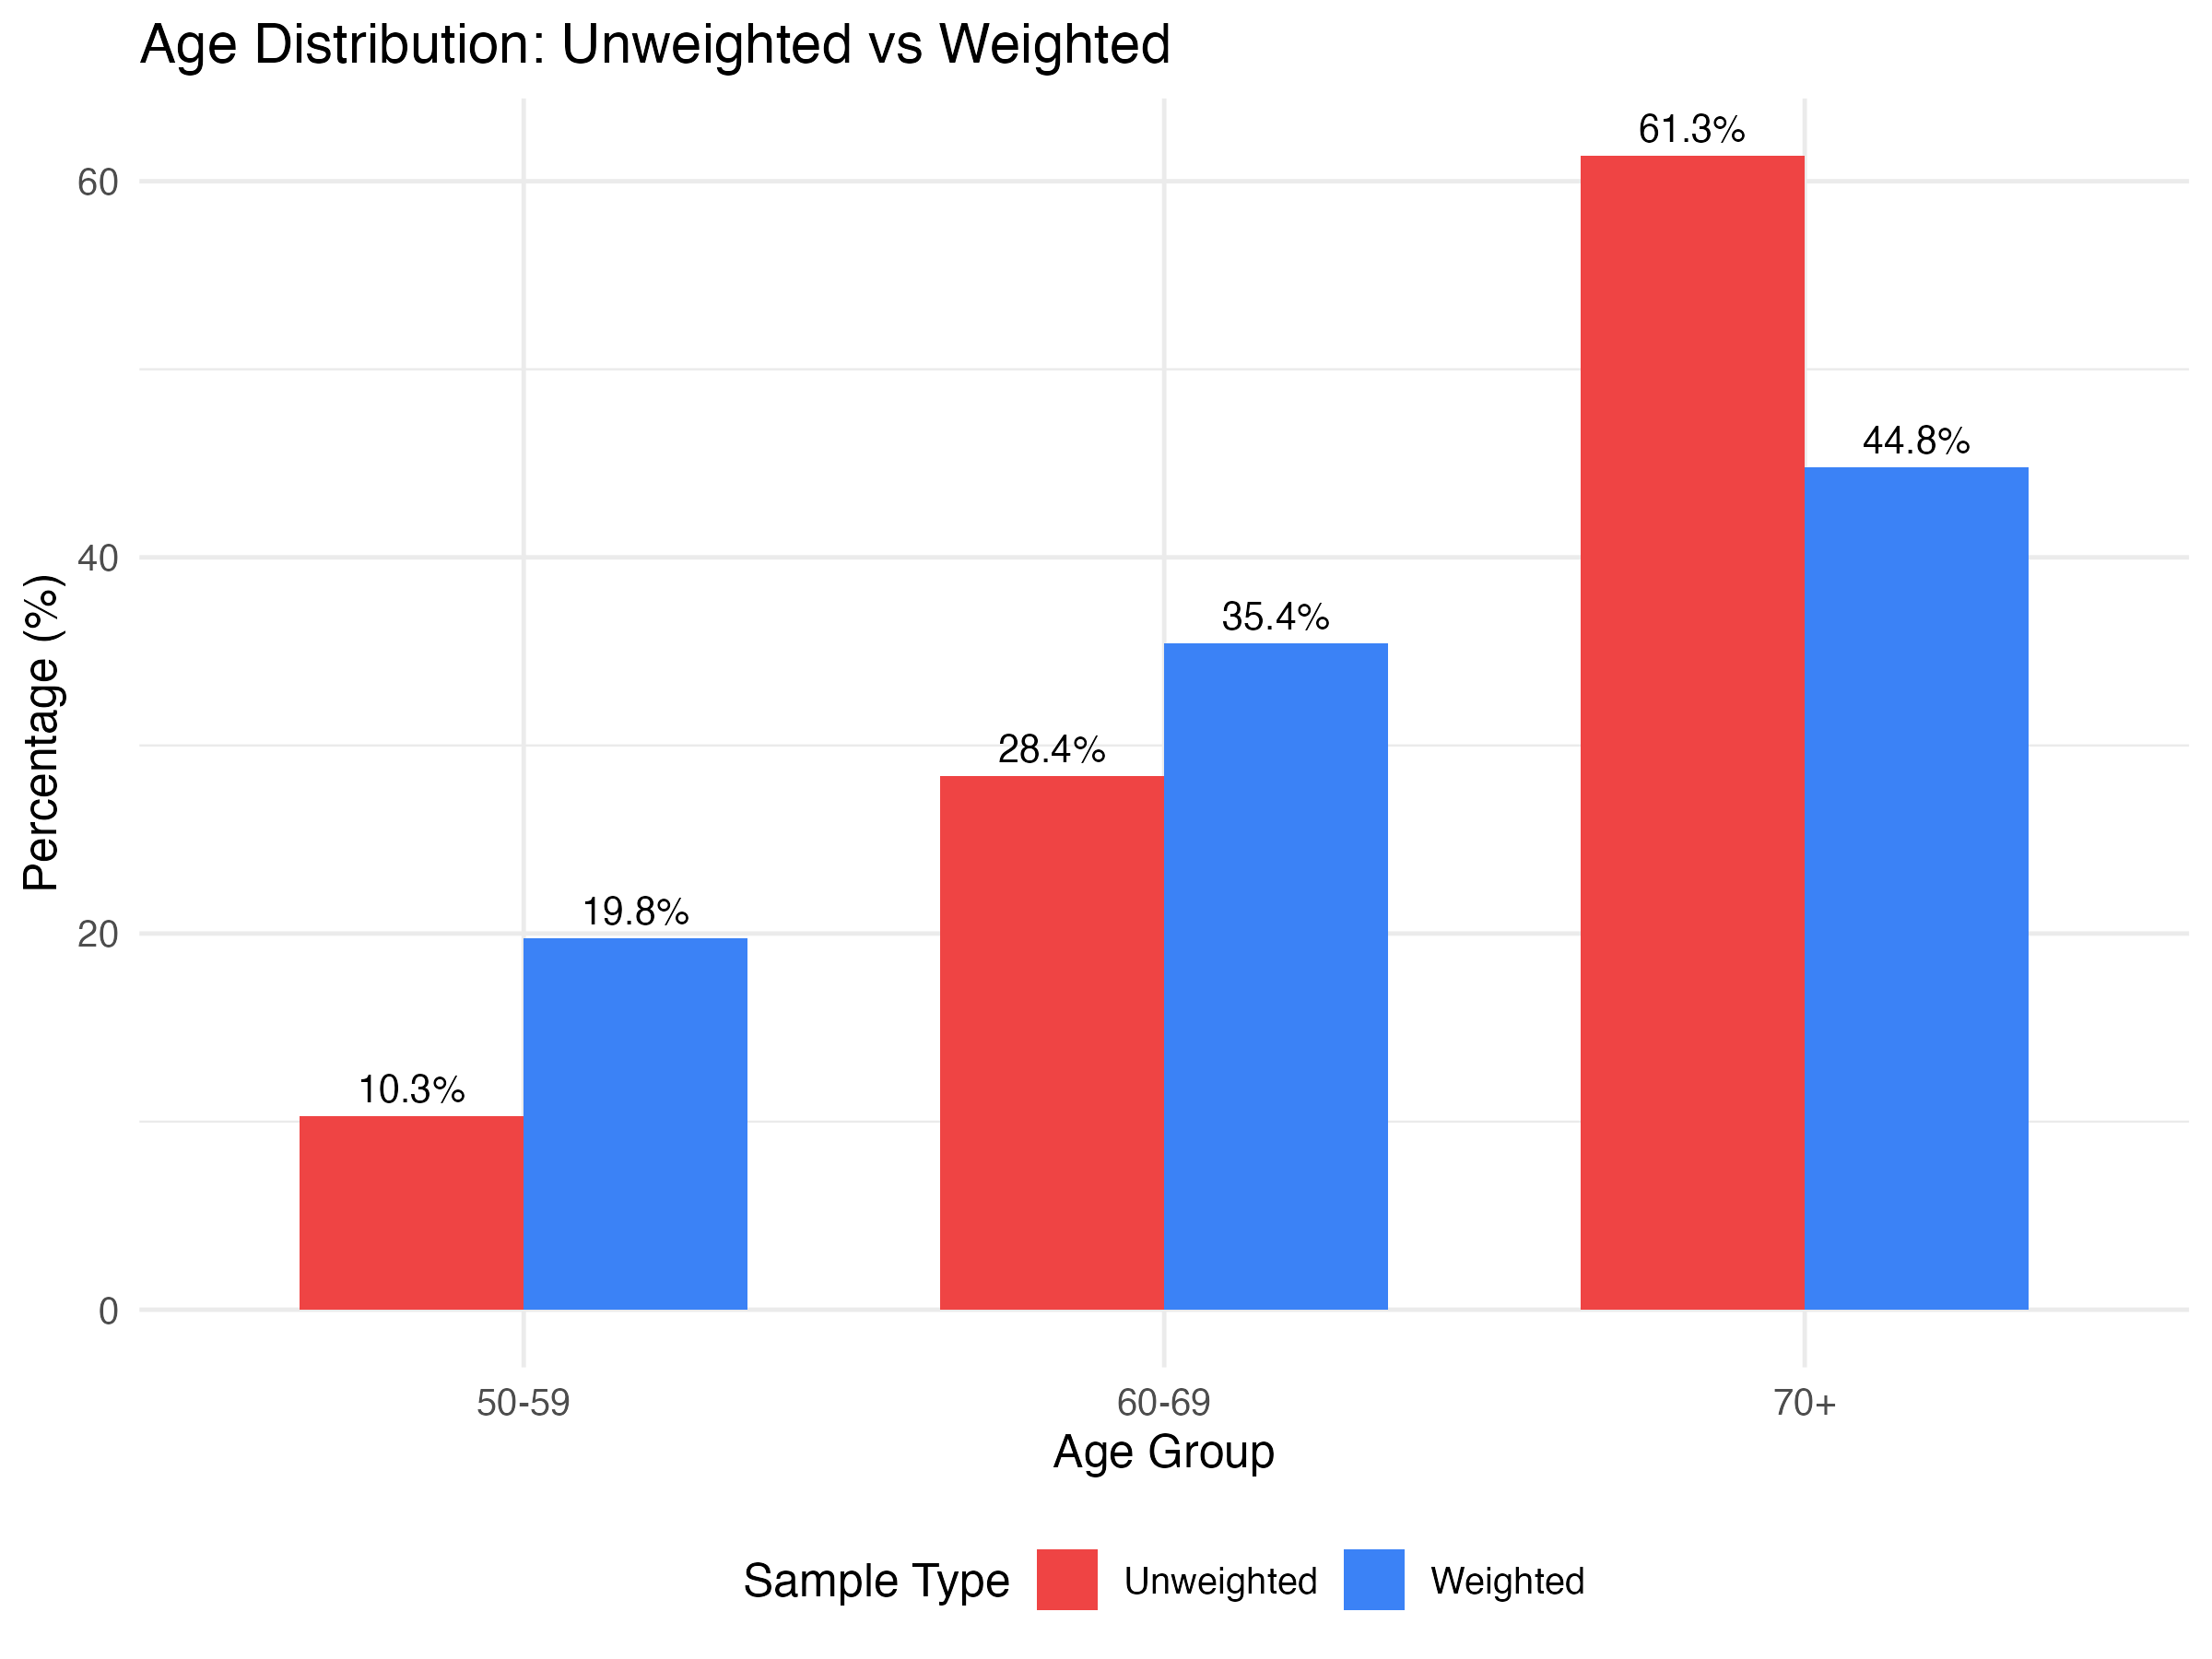

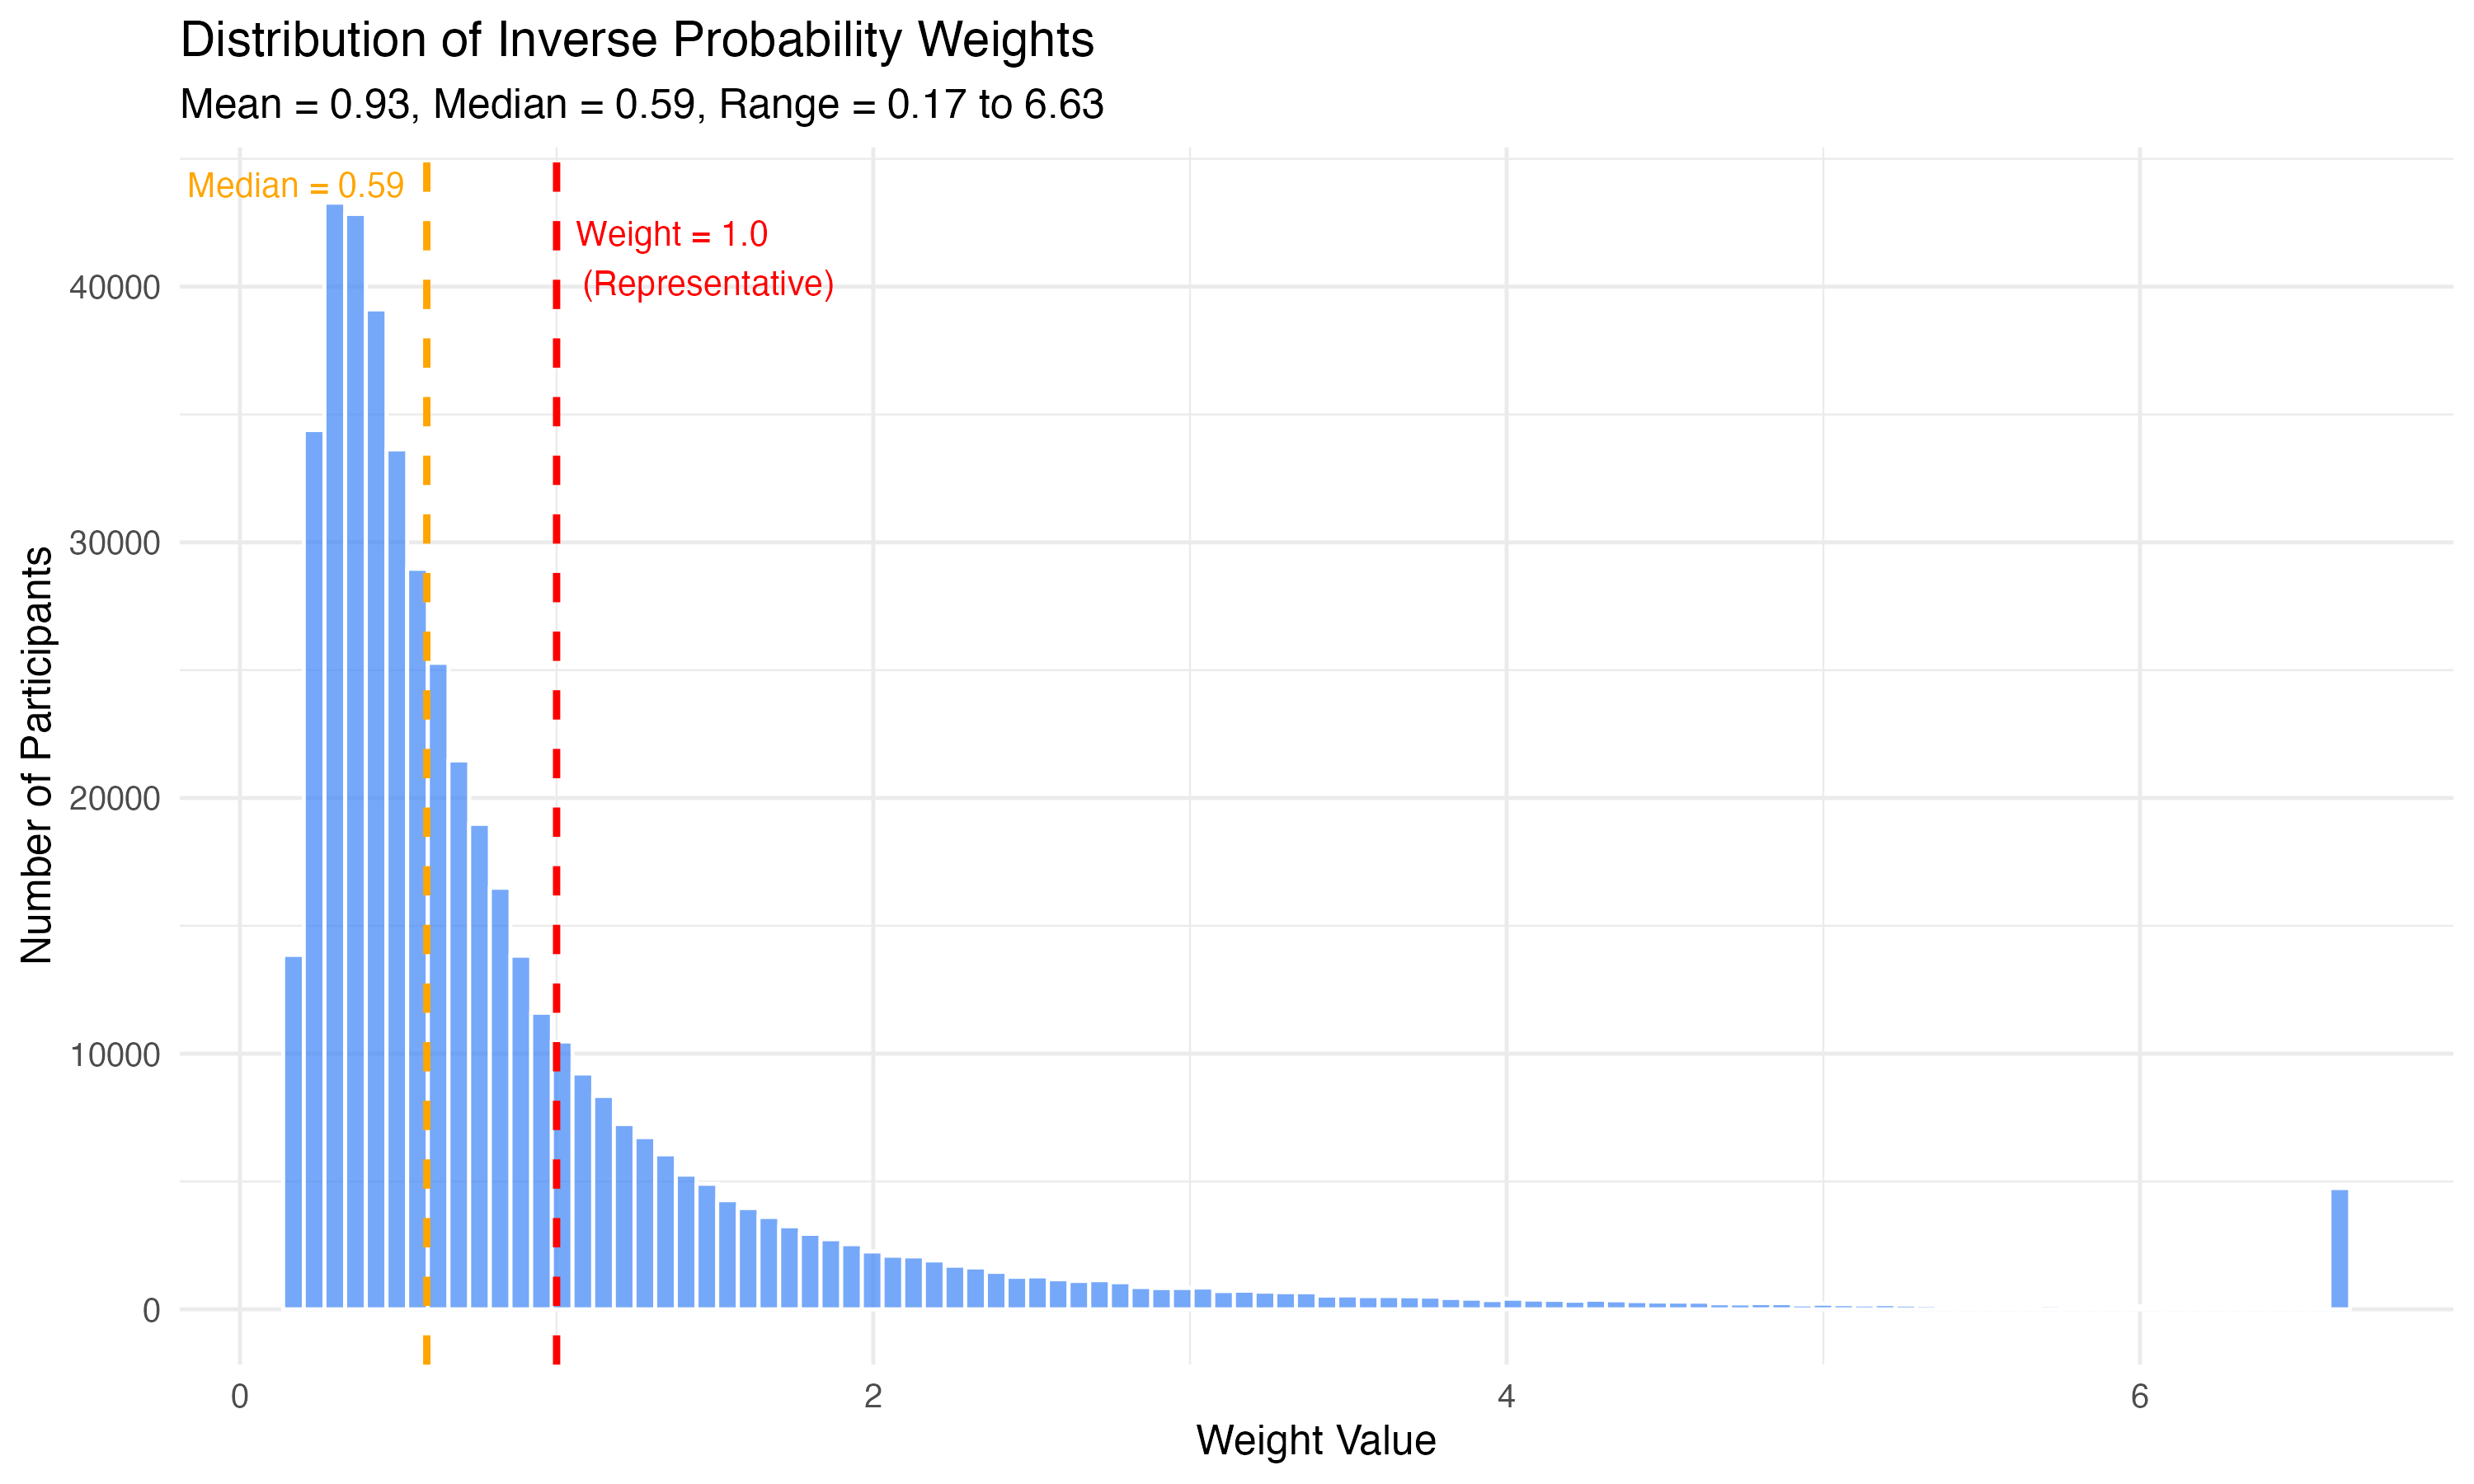

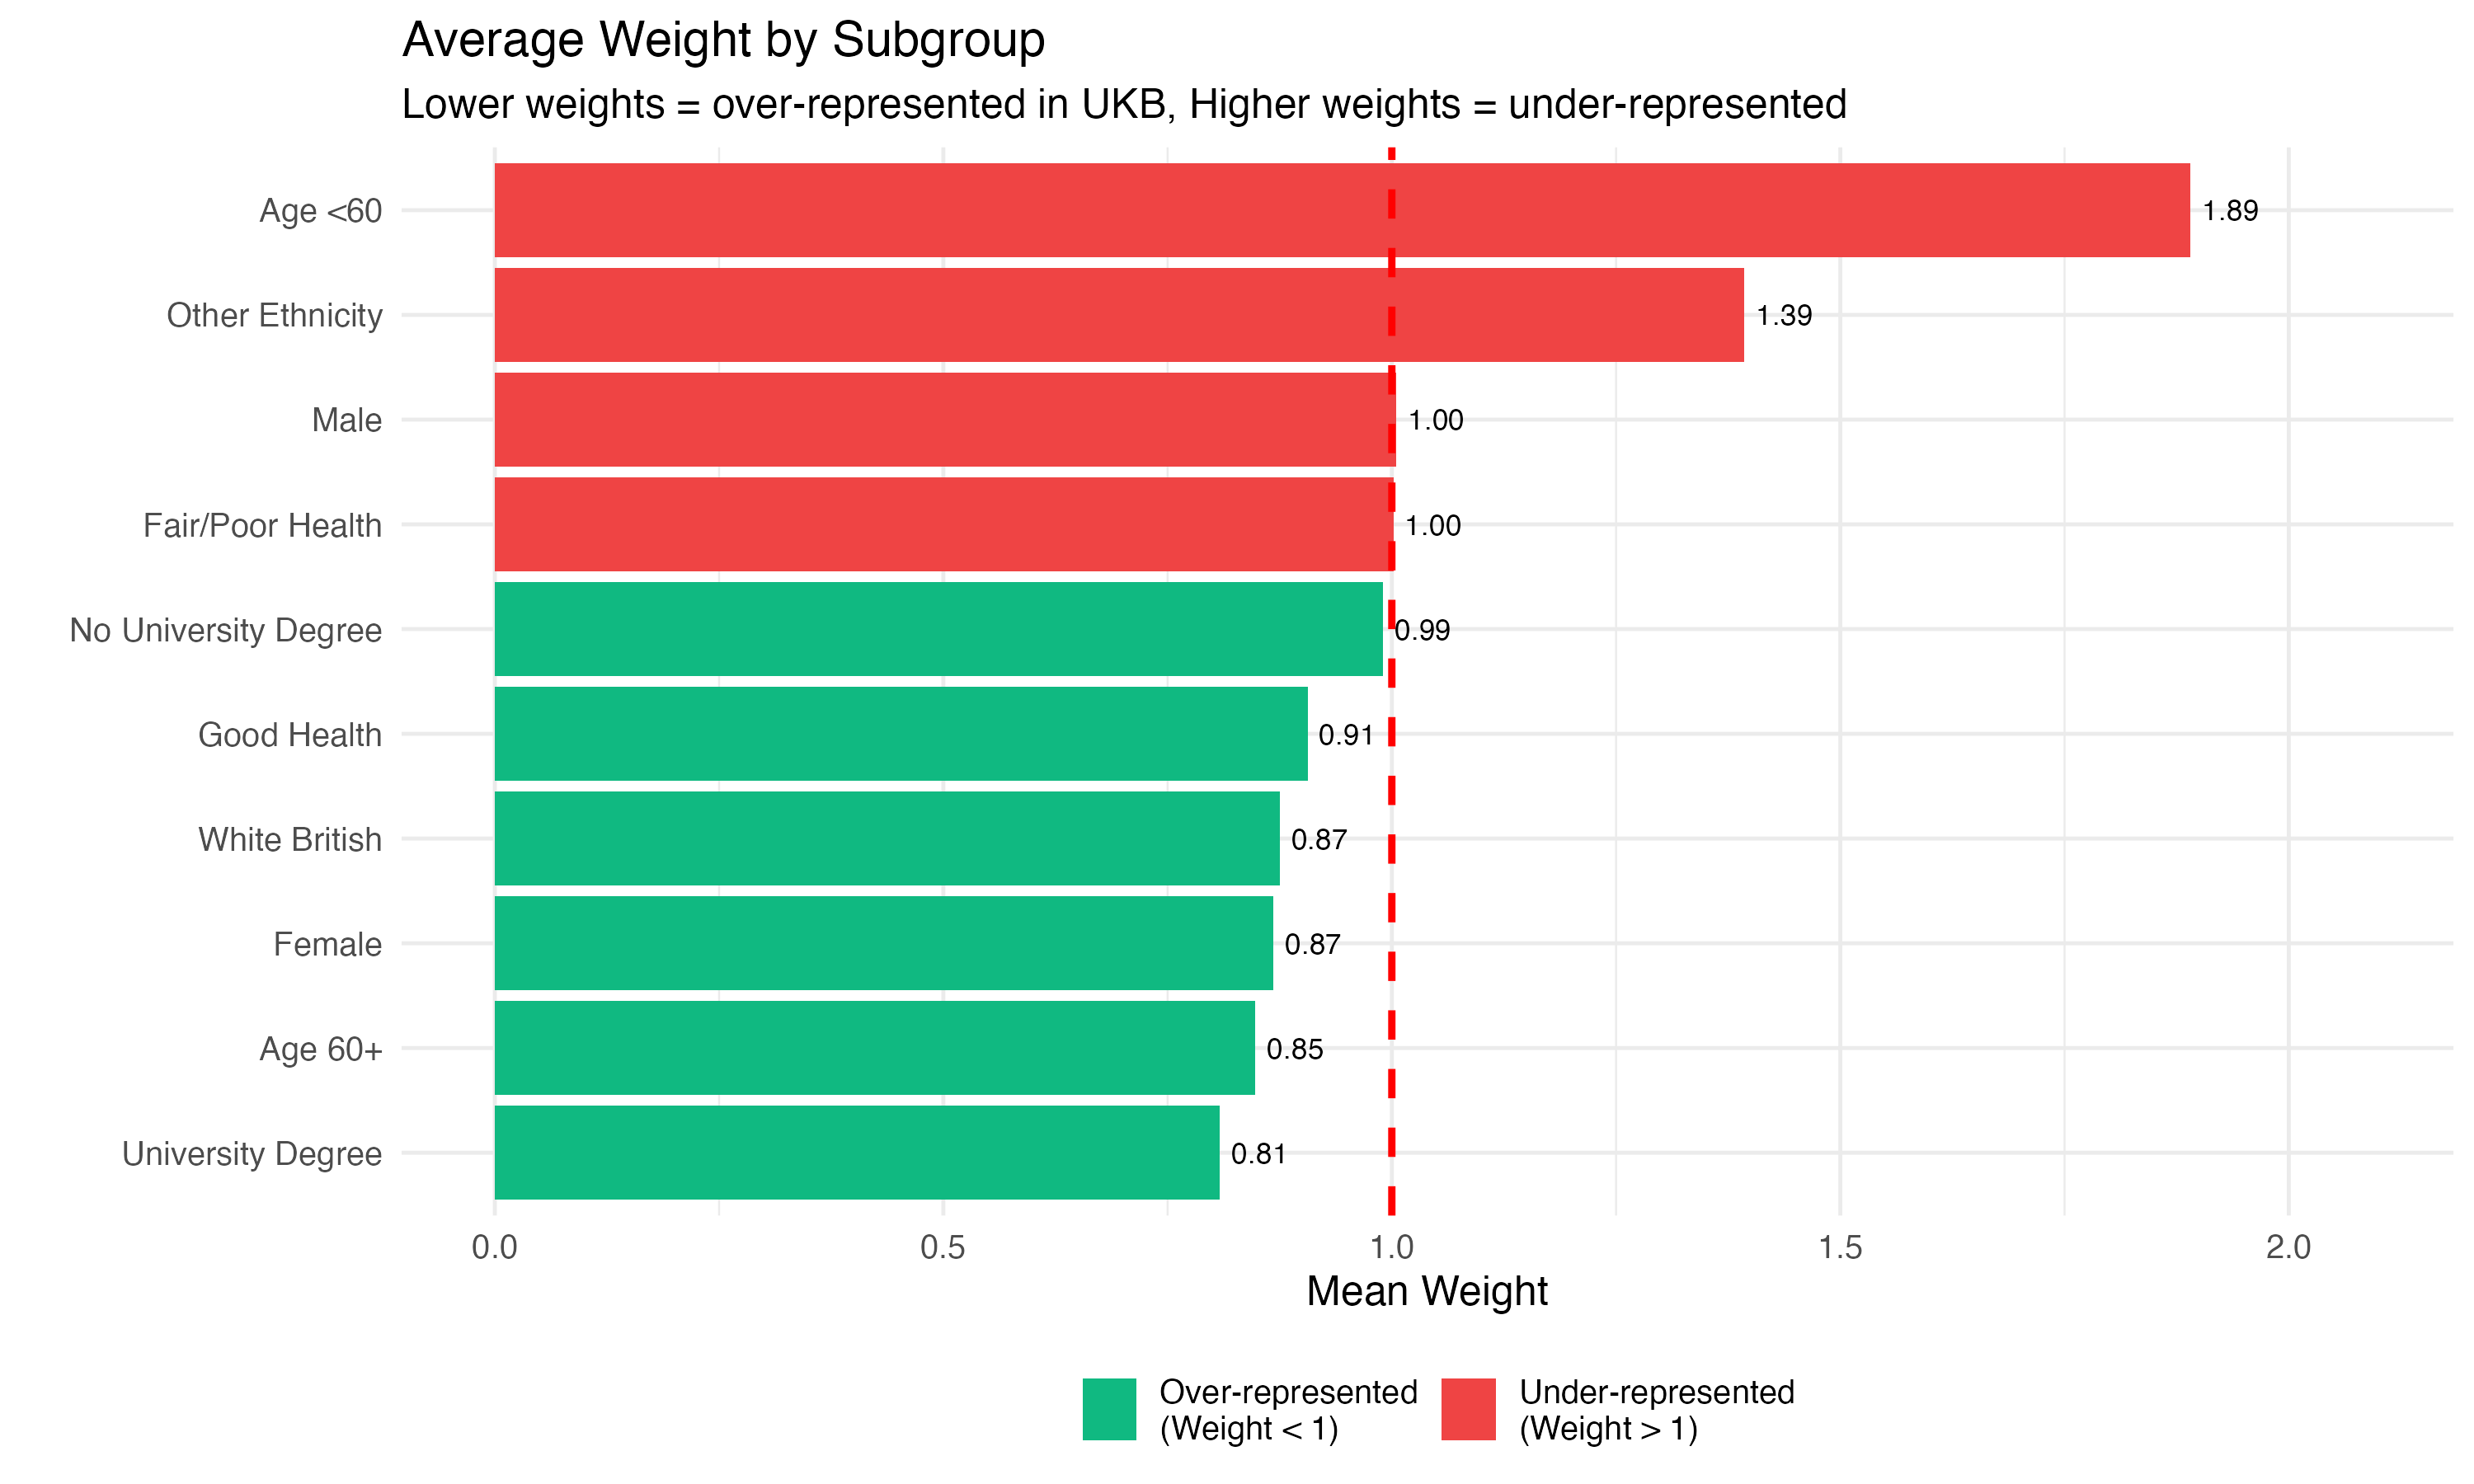

In [5]:
from IPython.display import display, Image

image_paths = [
    base_path / "ukb_weighting_comparison.png",
    base_path / "ukb_age_distribution.png",
    base_path / "ukb_weight_distribution.png",
    base_path / "ukb_weights_by_subgroup.png",
]

display(*(Image(filename=str(path)) for path in image_paths))


## Key Takeaways

- `LassoWeight` rebalances the UK Biobank sample toward older, less healthy, and non-White British participants who are under-represented in the unweighted cohort.
- Weighted Aladyn training (`weighted_aladyn.py`) rescaled the survival likelihood by these IPWs, while keeping GP priors unchanged.
- The weighted model remains well-aligned with historical phi signatures, but the comparison cells in `aladynoulli_fit_for_understanding_and_discovery_withweights.ipynb` highlight where disease-specific prevalence shifts are most pronounced.
- Use the exported CSVs/PNGs above for slide-ready visuals; rerun the full R notebook if refreshed plots or alternative subgroups are needed.

For further inspection, open the training notebook and scroll to the sections titled **FAIR PHI COMPARISON** and **SAMPLE DISEASE ANALYSIS**.


=== LOADING OLD MODEL BATCHES ===
Loading batch 0: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 1: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_10000_20000.pt


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49606/467778978.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=t

  Phi shape: torch.Size([21, 348, 52])
Loading batch 2: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_20000_30000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 3: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_30000_40000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 4: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_40000_50000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 5: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_50000_60000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 6: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_60000_70000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 7: /Users/sarahurbut/Library/CloudStorage/Dropbox/en

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49606/467778978.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_phi_data = torch.load(combined_phi_p

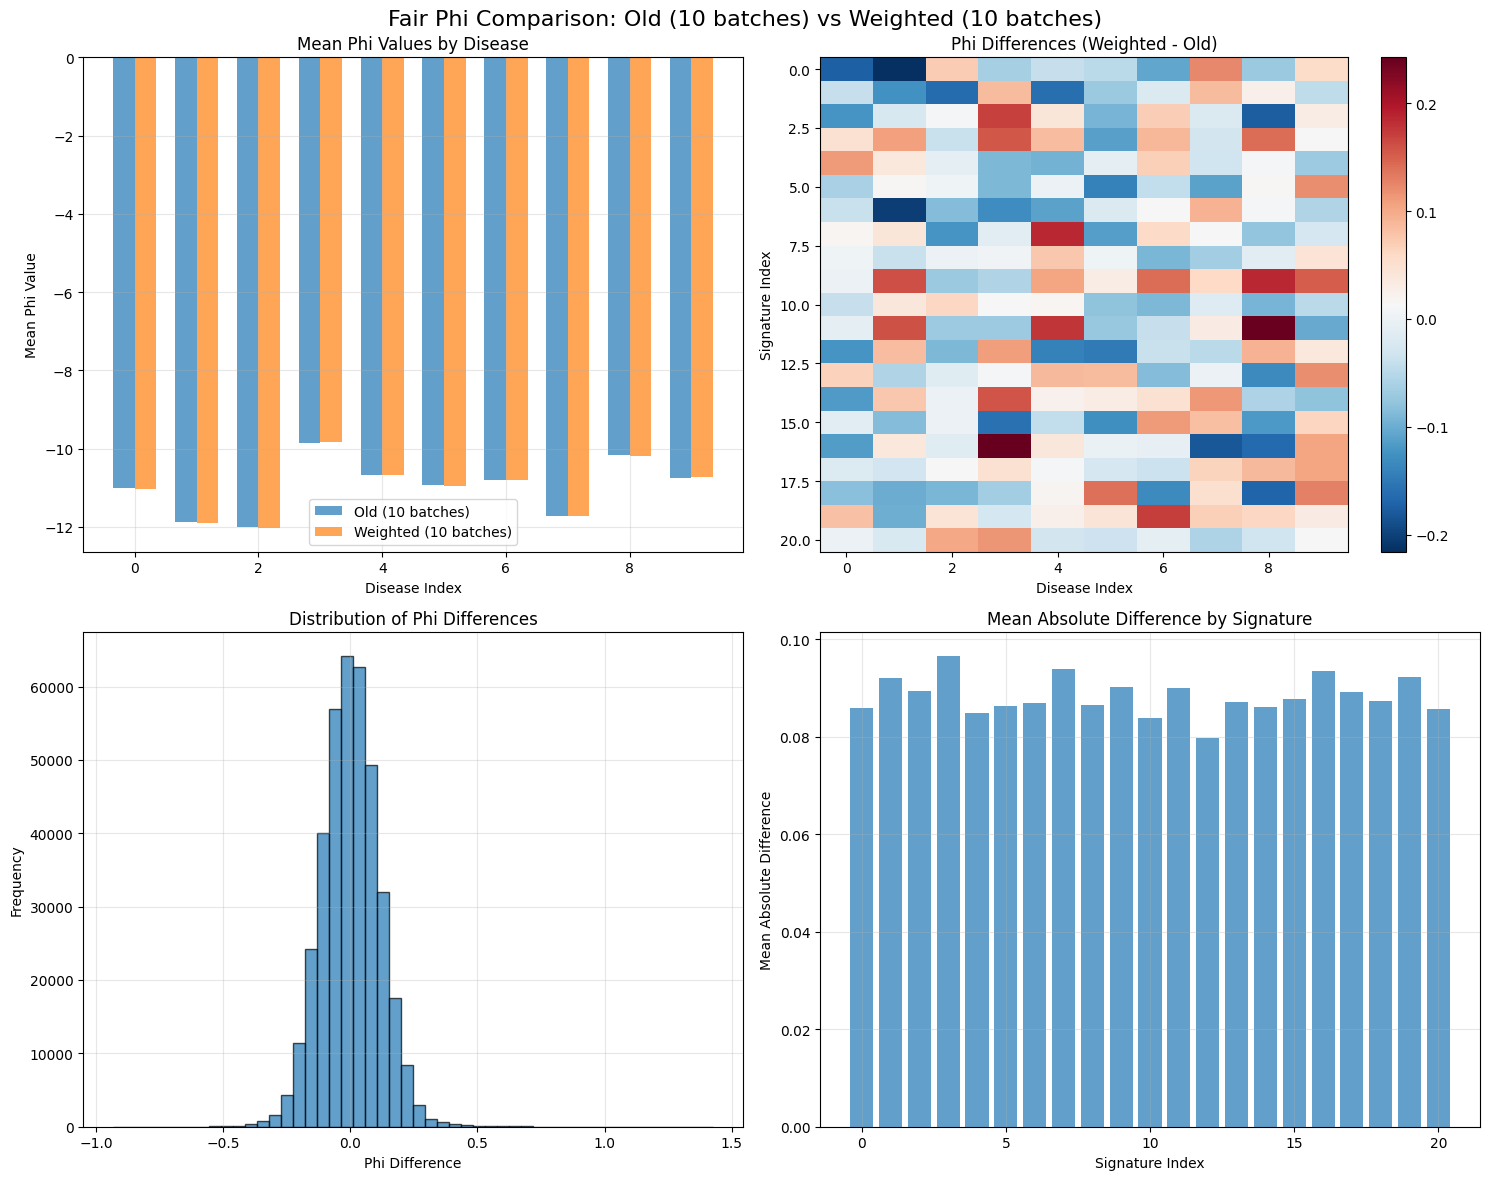

Fair phi comparison plot saved to: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/fair_phi_comparison.png

=== FAIR COMPARISON COMPLETE ===
Fair comparison results saved to: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/fair_phi_comparison_results.pt
Key findings:
  - Old model: 10 batches combined
  - Weighted model: 10 batches combined
  - Phi shapes match: True
  - Mean difference: 0.001870
  - Max absolute difference: 1.426461


In [6]:
# FIXED PHI COMPARISON: Detach tensors before plotting

import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the first 10 batches from the old model
old_model_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/'
print("=== LOADING OLD MODEL BATCHES ===")

old_phis = []
old_models = []

for batch_idx in range(10):
    model_path = os.path.join(old_model_dir, f'enrollment_model_W0.0001_batch_{batch_idx*10000}_{(batch_idx+1)*10000}.pt')
    
    if os.path.exists(model_path):
        print(f"Loading batch {batch_idx}: {model_path}")
        model = torch.load(model_path, map_location=torch.device('cpu'))
        old_phis.append(model['phi'].detach())  # Detach here
        old_models.append(model)
        print(f"  Phi shape: {model['phi'].shape}")
    else:
        print(f"⚠️  Batch {batch_idx} not found: {model_path}")

if len(old_phis) == 0:
    print("❌ No old model batches found!")
else:
    print(f"✅ Loaded {len(old_phis)} old model batches")
    
    # Combine phis from old models
    print("\n=== COMBINING OLD MODEL PHIS ===")
    phi_shape = old_phis[0].shape
    print(f"Phi shape: {phi_shape}")
    
    # Initialize combined old phi
    combined_old_phi = torch.zeros(phi_shape)
    
    # Sum phis from all old batches
    for i, phi in enumerate(old_phis):
        combined_old_phi += phi
        print(f"  Batch {i}: phi shape {phi.shape}")
    
    # Average the phis
    combined_old_phi /= len(old_phis)
    
    print(f"Combined old phi shape: {combined_old_phi.shape}")
    print(f"Combined old phi stats: mean={combined_old_phi.mean():.4f}, std={combined_old_phi.std():.4f}")

# Load combined phi from weighted training
print("\n=== LOADING WEIGHTED MODEL PHI ===")
combined_phi_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/combined_phi.pt'
combined_phi_data = torch.load(combined_phi_path, map_location=torch.device('cpu'))
combined_weighted_phi = combined_phi_data['phi'].detach()  # Detach here

print(f"Combined weighted phi shape: {combined_weighted_phi.shape}")
print(f"Combined weighted phi stats: mean={combined_weighted_phi.mean():.4f}, std={combined_weighted_phi.std():.4f}")
print(f"Combined from {combined_phi_data['num_batches']} batches")

# Compare the two combined phis
print(f"\n=== FAIR PHI COMPARISON ===")
print(f"Old model: {len(old_phis)} batches combined")
print(f"Weighted model: {combined_phi_data['num_batches']} batches combined")

# Check if shapes match
if combined_old_phi.shape != combined_weighted_phi.shape:
    print(f"⚠️  WARNING: Phi shapes don't match!")
    print(f"  Old combined: {combined_old_phi.shape}")
    print(f"  Weighted combined: {combined_weighted_phi.shape}")
else:
    print("✅ Phi shapes match!")

# Calculate differences
phi_diff = combined_weighted_phi - combined_old_phi
phi_abs_diff = torch.abs(phi_diff)

print(f"\n=== PHI DIFFERENCE STATISTICS ===")
print(f"Mean difference: {phi_diff.mean():.6f}")
print(f"Std difference: {phi_diff.std():.6f}")
print(f"Max absolute difference: {phi_abs_diff.max():.6f}")
print(f"Mean absolute difference: {phi_abs_diff.mean():.6f}")

# Create visualization comparing the two combined phis
def plot_fair_phi_comparison(old_phi, weighted_phi, max_diseases=10):
    """
    Plot comparison of combined phi values
    """
    K, D, T = old_phi.shape
    
    # Take first few diseases for visualization
    n_diseases = min(max_diseases, D)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Fair Phi Comparison: Old (10 batches) vs Weighted (10 batches)', fontsize=16)
    
    # 1. Mean phi values across time for each disease
    ax1 = axes[0, 0]
    old_mean = old_phi[:, :n_diseases, :].mean(dim=2).detach().numpy()  # Detach and convert to numpy
    weighted_mean = weighted_phi[:, :n_diseases, :].mean(dim=2).detach().numpy()
    
    x_pos = np.arange(n_diseases)
    width = 0.35
    
    ax1.bar(x_pos - width/2, old_mean.mean(axis=0), width, label='Old (10 batches)', alpha=0.7)
    ax1.bar(x_pos + width/2, weighted_mean.mean(axis=0), width, label='Weighted (10 batches)', alpha=0.7)
    ax1.set_xlabel('Disease Index')
    ax1.set_ylabel('Mean Phi Value')
    ax1.set_title('Mean Phi Values by Disease')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Difference heatmap
    ax2 = axes[0, 1]
    phi_diff_subset = phi_diff[:, :n_diseases, :].mean(dim=2).detach().numpy()  # Detach and convert
    im = ax2.imshow(phi_diff_subset, aspect='auto', cmap='RdBu_r')
    ax2.set_xlabel('Disease Index')
    ax2.set_ylabel('Signature Index')
    ax2.set_title('Phi Differences (Weighted - Old)')
    plt.colorbar(im, ax=ax2)
    
    # 3. Distribution of differences
    ax3 = axes[1, 0]
    phi_diff_flat = phi_diff.flatten().detach().numpy()  # Detach and convert
    ax3.hist(phi_diff_flat, bins=50, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Phi Difference')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Phi Differences')
    ax3.grid(True, alpha=0.3)
    
    # 4. Absolute differences by signature
    ax4 = axes[1, 1]
    phi_abs_diff_mean = phi_abs_diff.mean(dim=(1, 2)).detach().numpy()  # Detach and convert
    ax4.bar(range(K), phi_abs_diff_mean, alpha=0.7)
    ax4.set_xlabel('Signature Index')
    ax4.set_ylabel('Mean Absolute Difference')
    ax4.set_title('Mean Absolute Difference by Signature')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/fair_phi_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Fair phi comparison plot saved to: {plot_path}")

# Create the fair comparison plot
if len(old_phis) > 0:
    plot_fair_phi_comparison(combined_old_phi, combined_weighted_phi)
    
    # Save fair comparison results
    fair_comparison_results = {
        'old_model_dir': old_model_dir,
        'weighted_model_path': combined_phi_path,
        'old_batches_combined': len(old_phis),
        'weighted_batches_combined': combined_phi_data['num_batches'],
        'phi_shapes_match': combined_old_phi.shape == combined_weighted_phi.shape,
        'mean_difference': phi_diff.mean().item(),
        'std_difference': phi_diff.std().item(),
        'max_absolute_difference': phi_abs_diff.max().item(),
        'mean_absolute_difference': phi_abs_diff.mean().item()
    }
    
    fair_comparison_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/fair_phi_comparison_results.pt'
    torch.save(fair_comparison_results, fair_comparison_path)
    
    print(f"\n=== FAIR COMPARISON COMPLETE ===")
    print(f"Fair comparison results saved to: {fair_comparison_path}")
    print(f"Key findings:")
    print(f"  - Old model: {fair_comparison_results['old_batches_combined']} batches combined")
    print(f"  - Weighted model: {fair_comparison_results['weighted_batches_combined']} batches combined")
    print(f"  - Phi shapes match: {fair_comparison_results['phi_shapes_match']}")
    print(f"  - Mean difference: {fair_comparison_results['mean_difference']:.6f}")
    print(f"  - Max absolute difference: {fair_comparison_results['max_absolute_difference']:.6f}")
else:
    print("❌ Cannot perform fair comparison - no old model batches found!")

=== SAMPLE DISEASE PHI COMPARISON ===
Analyzing diseases: [112, 57, 19]


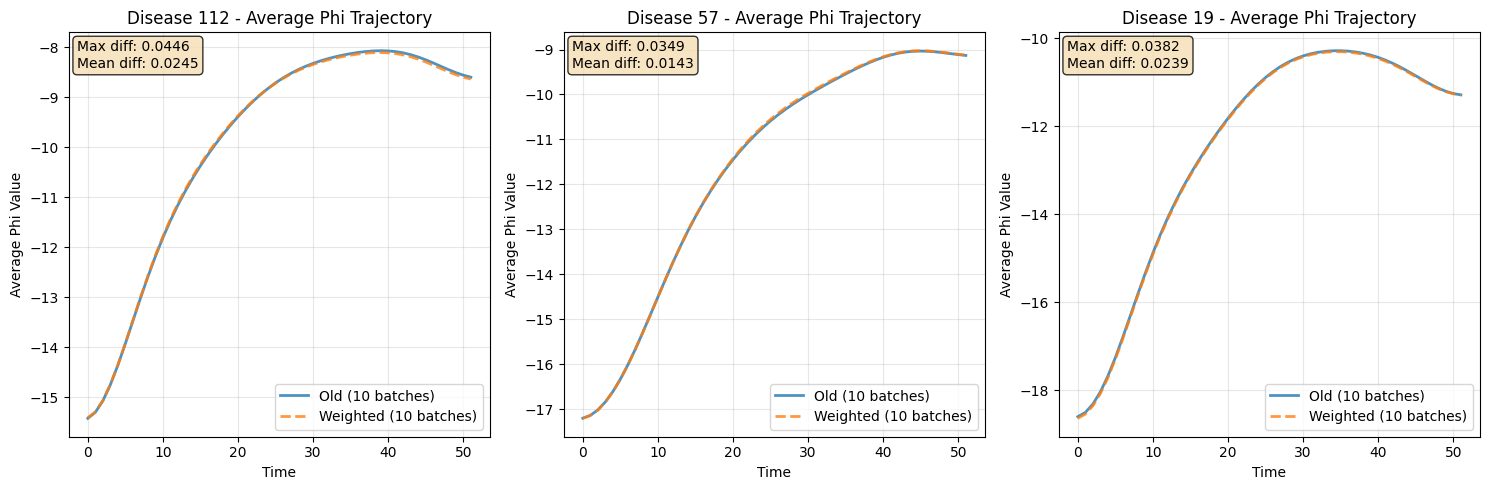

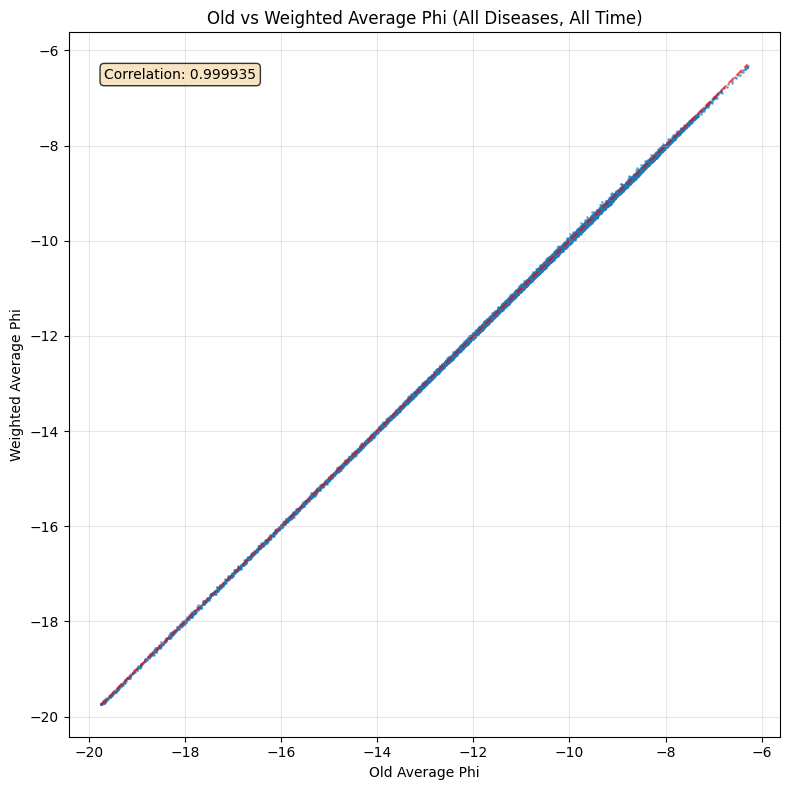

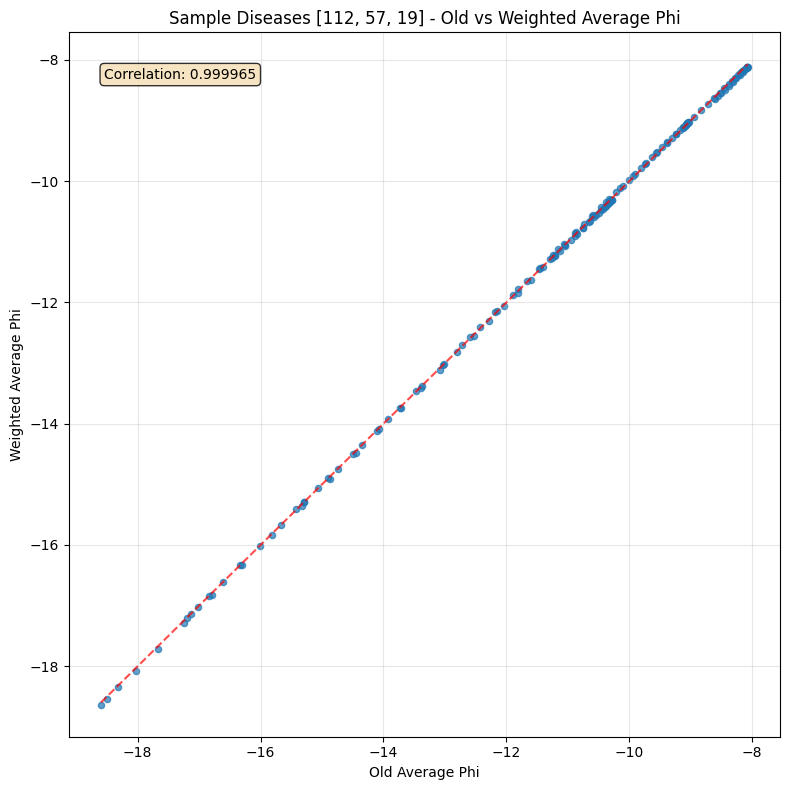


=== DETAILED STATISTICS FOR SAMPLE DISEASES ===

Disease 112:
  Mean old phi: -9.9095
  Mean weighted phi: -9.9179
  Mean difference: -0.008369
  Max absolute difference: 0.044627
  Mean absolute difference: 0.024529
  Correlation: 0.999957

Disease 57:
  Mean old phi: -11.6279
  Mean weighted phi: -11.6152
  Mean difference: 0.012652
  Max absolute difference: 0.034880
  Mean absolute difference: 0.014319
  Correlation: 0.999993

Disease 19:
  Mean old phi: -12.5003
  Mean weighted phi: -12.5242
  Mean difference: -0.023901
  Max absolute difference: 0.038214
  Mean absolute difference: 0.023901
  Correlation: 0.999998

=== OVERALL STATISTICS ===
Overall correlation: 0.999935
Overall mean difference: 0.001870
Overall max absolute difference: 0.133832
Overall mean absolute difference: 0.020008

✅ Sample disease analysis complete!


In [7]:
# SAMPLE DISEASE ANALYSIS: Compare old vs weighted phi for specific diseases

import matplotlib.pyplot as plt
import numpy as np

# Define sample diseases to analyze
sample_diseases = [112, 57, 19]  # You can change these to any disease indices you want
disease_names = ['Myocardial Infarction', 'Type 2 Diabetes', 'Essential Hypertension']  # Optional names

print("=== SAMPLE DISEASE PHI COMPARISON ===")
print(f"Analyzing diseases: {sample_diseases}")

# Calculate average phi across signatures for each disease
old_avg_phi = combined_old_phi.mean(dim=0)  # Average across signatures: shape (348, 52)
weighted_avg_phi = combined_weighted_phi.mean(dim=0)  # Average across signatures: shape (348, 52)

# 1. Plot averaged phi trajectories for sample diseases
fig, axes = plt.subplots(1, len(sample_diseases), figsize=(15, 5))
if len(sample_diseases) == 1:
    axes = [axes]

for i, disease_idx in enumerate(sample_diseases):
    ax = axes[i]
    
    # Get trajectories for this disease
    old_traj = old_avg_phi[disease_idx, :].detach().numpy()
    weighted_traj = weighted_avg_phi[disease_idx, :].detach().numpy()
    
    # Plot trajectories
    ax.plot(old_traj, label='Old (10 batches)', linewidth=2, alpha=0.8)
    ax.plot(weighted_traj, label='Weighted (10 batches)', linewidth=2, alpha=0.8, linestyle='--')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Phi Value')
    ax.set_title(f'Disease {disease_idx} - Average Phi Trajectory')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add some statistics
    diff = np.abs(weighted_traj - old_traj)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)
    ax.text(0.02, 0.98, f'Max diff: {max_diff:.4f}\nMean diff: {mean_diff:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 2. Scatter plot of all old vs weighted average phi values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Flatten all values for scatter plot
old_flat = old_avg_phi.detach().numpy().flatten()
weighted_flat = weighted_avg_phi.detach().numpy().flatten()

# Create scatter plot
ax.scatter(old_flat, weighted_flat, alpha=0.5, s=1)
ax.plot([old_flat.min(), old_flat.max()], [old_flat.min(), old_flat.max()], 'r--', alpha=0.7)

ax.set_xlabel('Old Average Phi')
ax.set_ylabel('Weighted Average Phi')
ax.set_title('Old vs Weighted Average Phi (All Diseases, All Time)')
ax.grid(True, alpha=0.3)

# Calculate correlation
correlation = np.corrcoef(old_flat, weighted_flat)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {correlation:.6f}', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 3. Focus on sample diseases scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Get values for sample diseases only
sample_old_values = []
sample_weighted_values = []

for disease_idx in sample_diseases:
    old_vals = old_avg_phi[disease_idx, :].detach().numpy()
    weighted_vals = weighted_avg_phi[disease_idx, :].detach().numpy()
    
    sample_old_values.extend(old_vals)
    sample_weighted_values.extend(weighted_vals)

sample_old_values = np.array(sample_old_values)
sample_weighted_values = np.array(sample_weighted_values)

# Create scatter plot for sample diseases
ax.scatter(sample_old_values, sample_weighted_values, alpha=0.7, s=20)
ax.plot([sample_old_values.min(), sample_old_values.max()], 
        [sample_old_values.min(), sample_old_values.max()], 'r--', alpha=0.7)

ax.set_xlabel('Old Average Phi')
ax.set_ylabel('Weighted Average Phi')
ax.set_title(f'Sample Diseases {sample_diseases} - Old vs Weighted Average Phi')
ax.grid(True, alpha=0.3)

# Calculate correlation for sample diseases
sample_correlation = np.corrcoef(sample_old_values, sample_weighted_values)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {sample_correlation:.6f}', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 4. Print detailed statistics for sample diseases
print(f"\n=== DETAILED STATISTICS FOR SAMPLE DISEASES ===")
for i, disease_idx in enumerate(sample_diseases):
    old_traj = old_avg_phi[disease_idx, :].detach().numpy()
    weighted_traj = weighted_avg_phi[disease_idx, :].detach().numpy()
    
    diff = weighted_traj - old_traj
    abs_diff = np.abs(diff)
    
    print(f"\nDisease {disease_idx}:")
    print(f"  Mean old phi: {old_traj.mean():.4f}")
    print(f"  Mean weighted phi: {weighted_traj.mean():.4f}")
    print(f"  Mean difference: {diff.mean():.6f}")
    print(f"  Max absolute difference: {abs_diff.max():.6f}")
    print(f"  Mean absolute difference: {abs_diff.mean():.6f}")
    print(f"  Correlation: {np.corrcoef(old_traj, weighted_traj)[0, 1]:.6f}")

# 5. Overall statistics
print(f"\n=== OVERALL STATISTICS ===")
overall_correlation = np.corrcoef(old_flat, weighted_flat)[0, 1]
overall_diff = weighted_flat - old_flat
overall_abs_diff = np.abs(overall_diff)

print(f"Overall correlation: {overall_correlation:.6f}")
print(f"Overall mean difference: {overall_diff.mean():.6f}")
print(f"Overall max absolute difference: {overall_abs_diff.max():.6f}")
print(f"Overall mean absolute difference: {overall_abs_diff.mean():.6f}")

print(f"\n✅ Sample disease analysis complete!")

=== SAMPLE DISEASE PHI COMPARISON (PER SIGNATURE) ===
Analyzing diseases: [112, 57, 47, 19]


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49606/672146848.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


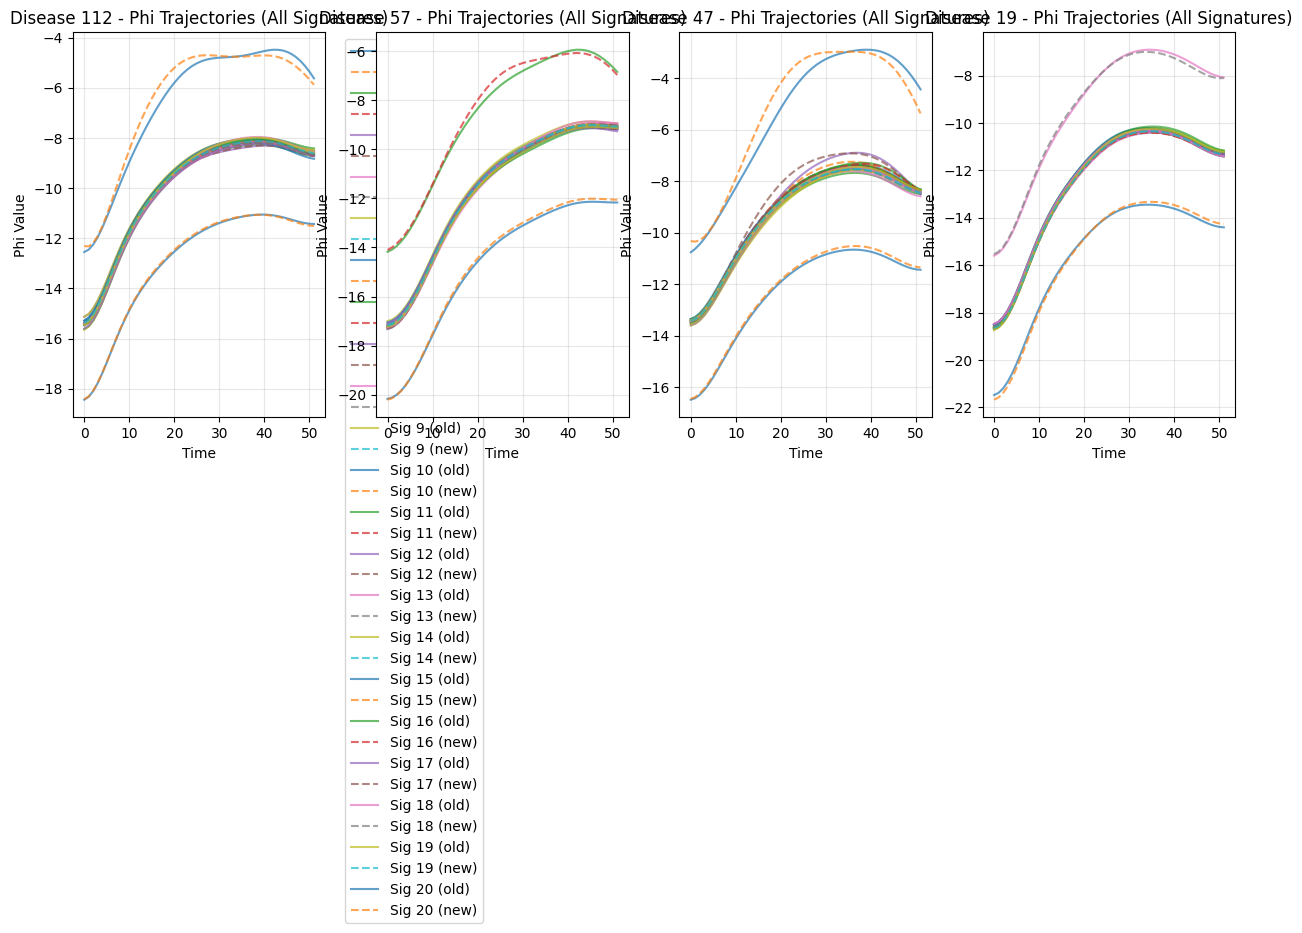

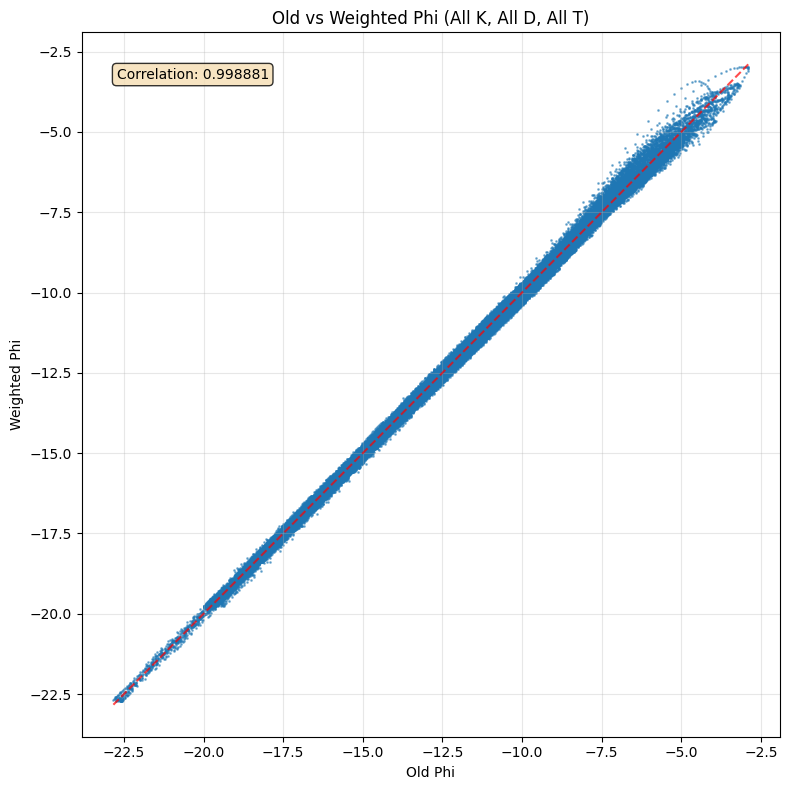

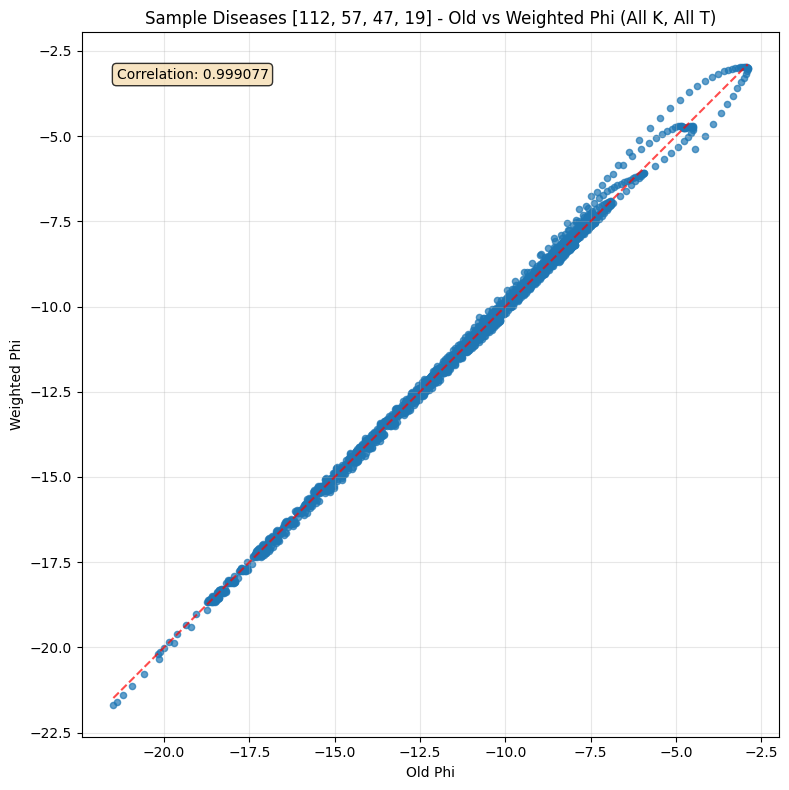


=== DETAILED STATISTICS FOR SAMPLE DISEASES (PER SIGNATURE) ===

Disease 112:
  Signature 0:
    Mean old phi: -9.9337
    Mean weighted phi: -9.8993
    Mean difference: 0.034369
    Max absolute difference: 0.098351
    Mean absolute difference: 0.063242
    Correlation: 0.999723
  Signature 1:
    Mean old phi: -9.9560
    Mean weighted phi: -10.0012
    Mean difference: -0.045263
    Max absolute difference: 0.269422
    Mean absolute difference: 0.160083
    Correlation: 0.999594
  Signature 2:
    Mean old phi: -9.8786
    Mean weighted phi: -9.9843
    Mean difference: -0.105664
    Max absolute difference: 0.188165
    Mean absolute difference: 0.105664
    Correlation: 0.999861
  Signature 3:
    Mean old phi: -9.9291
    Mean weighted phi: -9.9620
    Mean difference: -0.032898
    Max absolute difference: 0.129750
    Mean absolute difference: 0.039149
    Correlation: 0.999834
  Signature 4:
    Mean old phi: -9.8184
    Mean weighted phi: -9.9199
    Mean difference: -0.1

In [8]:
# CORRECTED SAMPLE DISEASE ANALYSIS: Compare old vs weighted phi for each signature

import matplotlib.pyplot as plt
import numpy as np

# Define sample diseases to analyze
sample_diseases = [112,57,47,19]  # You can change these to any disease indices you want

print("=== SAMPLE DISEASE PHI COMPARISON (PER SIGNATURE) ===")
print(f"Analyzing diseases: {sample_diseases}")

# 1. Plot phi trajectories for each signature for sample diseases
fig, axes = plt.subplots(1, len(sample_diseases), figsize=(15, 5))
if len(sample_diseases) == 1:
    axes = [axes]

for i, disease_idx in enumerate(sample_diseases):
    ax = axes[i]
    
    # Plot phi trajectories for each signature (K) for this disease
    for k in range(combined_old_phi.shape[0]):  # All signatures (K=21)
        old_traj = combined_old_phi[k, disease_idx, :].detach().numpy()
        weighted_traj = combined_weighted_phi[k, disease_idx, :].detach().numpy()
        
        ax.plot(old_traj, alpha=0.7, linestyle='-', label=f'Sig {k} (old)' if i == 0 else "")
        ax.plot(weighted_traj, alpha=0.7, linestyle='--', label=f'Sig {k} (new)' if i == 0 else "")
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Phi Value')
    ax.set_title(f'Disease {disease_idx} - Phi Trajectories (All Signatures)')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 2. Scatter plot of all old vs weighted phi values (each K, each D, each T)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Flatten all values for scatter plot (K, D, T)
old_flat = combined_old_phi.detach().numpy().flatten()
weighted_flat = combined_weighted_phi.detach().numpy().flatten()

# Create scatter plot
ax.scatter(old_flat, weighted_flat, alpha=0.5, s=1)
ax.plot([old_flat.min(), old_flat.max()], [old_flat.min(), old_flat.max()], 'r--', alpha=0.7)

ax.set_xlabel('Old Phi')
ax.set_ylabel('Weighted Phi')
ax.set_title('Old vs Weighted Phi (All K, All D, All T)')
ax.grid(True, alpha=0.3)

# Calculate correlation
correlation = np.corrcoef(old_flat, weighted_flat)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {correlation:.6f}', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 3. Focus on sample diseases scatter plot (each K, each T for sample diseases)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Get values for sample diseases only (each K, each T)
sample_old_values = []
sample_weighted_values = []

for disease_idx in sample_diseases:
    for k in range(combined_old_phi.shape[0]):  # All signatures
        old_vals = combined_old_phi[k, disease_idx, :].detach().numpy()
        weighted_vals = combined_weighted_phi[k, disease_idx, :].detach().numpy()
        
        sample_old_values.extend(old_vals)
        sample_weighted_values.extend(weighted_vals)

sample_old_values = np.array(sample_old_values)
sample_weighted_values = np.array(sample_weighted_values)

# Create scatter plot for sample diseases
ax.scatter(sample_old_values, sample_weighted_values, alpha=0.7, s=20)
ax.plot([sample_old_values.min(), sample_old_values.max()], 
        [sample_old_values.min(), sample_old_values.max()], 'r--', alpha=0.7)

ax.set_xlabel('Old Phi')
ax.set_ylabel('Weighted Phi')
ax.set_title(f'Sample Diseases {sample_diseases} - Old vs Weighted Phi (All K, All T)')
ax.grid(True, alpha=0.3)

# Calculate correlation for sample diseases
sample_correlation = np.corrcoef(sample_old_values, sample_weighted_values)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {sample_correlation:.6f}', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 4. Print detailed statistics for sample diseases (per signature)
print(f"\n=== DETAILED STATISTICS FOR SAMPLE DISEASES (PER SIGNATURE) ===")
for i, disease_idx in enumerate(sample_diseases):
    print(f"\nDisease {disease_idx}:")
    
    for k in range(combined_old_phi.shape[0]):  # All signatures
        old_traj = combined_old_phi[k, disease_idx, :].detach().numpy()
        weighted_traj = combined_weighted_phi[k, disease_idx, :].detach().numpy()
        
        diff = weighted_traj - old_traj
        abs_diff = np.abs(diff)
        
        print(f"  Signature {k}:")
        print(f"    Mean old phi: {old_traj.mean():.4f}")
        print(f"    Mean weighted phi: {weighted_traj.mean():.4f}")
        print(f"    Mean difference: {diff.mean():.6f}")
        print(f"    Max absolute difference: {abs_diff.max():.6f}")
        print(f"    Mean absolute difference: {abs_diff.mean():.6f}")
        print(f"    Correlation: {np.corrcoef(old_traj, weighted_traj)[0, 1]:.6f}")

# 5. Overall statistics
print(f"\n=== OVERALL STATISTICS ===")
overall_correlation = np.corrcoef(old_flat, weighted_flat)[0, 1]
overall_diff = weighted_flat - old_flat
overall_abs_diff = np.abs(overall_diff)

print(f"Overall correlation: {overall_correlation:.6f}")
print(f"Overall mean difference: {overall_diff.mean():.6f}")
print(f"Overall max absolute difference: {overall_abs_diff.max():.6f}")
print(f"Overall mean absolute difference: {overall_abs_diff.mean():.6f}")

print(f"\n✅ Sample disease analysis complete!")